# Evaluating a model's robustness

This notebook will take you through the process of evaluating the robustness of a trained model to some of the available transforms.

If you haven't already, make a copy of this Tutorials directory and a put it in the directory you want to work in.

Install the toolbox

In [1]:
!pip install reetoolbox

     |████████████████████████████████| 54 kB 2.5 MB/s 
  Created wheel for reetoolbox: filename=reetoolbox-0.1.0-py3-none-any.whl size=15761 sha256=7006f551a4fd57d76ca28bce6df4de789764f0dd83aaa0be18f72a9f98941f1c
  Stored in directory: /root/.cache/pip/wheels/7b/67/32/58fb18b077c661c8037f07368b00421439401f770d64b2ad81
Successfully built reetoolbox
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111


If you're using Google Colab, you need to mount your drive using the cell below. Otherwise you can skip this.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


You must set the variable PATH to the directory containing this file. It will probably look like the below path if you cloned the https://github.com/alexjfoote/reetoolbox-tutorials repo to your Google Drive.

In [2]:
PATH = "/content/drive/My Drive/reetoolbox-tutorials"

Import some useful functions

In [3]:
from reetoolbox.utils import load_resnet, load_pannuke, get_dataloader

Define the device we're using and the class names

In [4]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ["Negative", "Positive"]

Load an existing model trained to classify Whole Slide Image patches as non-tumorous (negative) or tumorous (positive).

In [5]:
import os

model_path = os.path.join(PATH, "Models/std_pre_std_train.pt")
model = load_resnet(model_path, device=device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Load the corresponding PanNuke dataset (see https://jgamper.github.io/PanNukeDataset/,  J. Gamper, N. A. Koohbanani, K. Benet, A. Khuram, and N. Rajpoot,
“PanNuke: An Open Pan-Cancer Histology Dataset for Nuclei Instance
Segmentation and Classification,” in Digital Pathology, pp. 11–19,
Springer, Cham, Apr. 2019.)

In [7]:
data_path = os.path.join(PATH, "Data/breast_folds.npz")
Xtr, ytr, Xts, yts = load_pannuke(data_path)

Create a PyTorch dataset and dataloaders, which we give to the evaluator later. We can specify the number of examples to include in the dataloaders, to control how much of the dataset we use for evaluation.

In [8]:
test_dataset = torch.utils.data.TensorDataset(Xts, yts)

batch_size = 4
small_loader = get_dataloader(test_dataset, n=100, batch_size=batch_size)
full_loader =  get_dataloader(test_dataset, n=None, batch_size=batch_size)

Import transforms, optimisers, the evaluator, and some metrics from the toolbox, as well as some more handy functions

In [9]:
from reetoolbox.utils import plot_change, display_results

from reetoolbox.transforms import StainTransform, RotateTransform
from reetoolbox.optimisers import PGD, StochasticSearch
from reetoolbox.evaluator import Evaluator
from reetoolbox.metrics import accuracy, adversarial_accuracy, fooling_rate, get_metrics

Here we set up an evaluator object that uses the stain transform. To do this, we need to give the evaluator our model, dataset, dataloader, optimiser, transform, optimiser parameters, transform parameters, and device.

Of these, we still need to get the optimiser and transform parameters. The simplest way is to load the default parameters from `constants.py`. The naming convention is `eval_(transform name)_(transform or optimiser)_params`. For example, below we access the optimiser parameters for the stain transform using `eval_stain_optimiser_params`.

In [10]:
from reetoolbox.constants import eval_stain_transform_params, eval_stain_optimiser_params

# Create the evaluator
stain_evaluator = Evaluator(model, test_dataset, small_loader, PGD, 
                            StainTransform, eval_stain_optimiser_params, 
                            eval_stain_transform_params, device=device)

We use the evaluator to get the results of the model on the data. By passing `adversarial=True`, we get the results on both the normal and adversarially transformed data. We can then pass the results object to metric functions measure various aspects of performance.

In [11]:
results = stain_evaluator.predict(adversarial=True)

# Compute some specific metrics
acc = accuracy(results)
robust_acc = adversarial_accuracy(results)
fool_rate = fooling_rate(results)
print(f"Accuracy: {acc:.3f}, robust accuracy: {robust_acc:.3f}, fooling rate: {fool_rate:.3f}%")

# Compute a standard set of metrics
get_metrics(results)

Accuracy: 0.930, robust accuracy: 0.420, fooling rate: 54.839%
Accuracy: 0.930, robust accuracy: 0.420, fooling ratio: 0.548


We can also define custom parameters for an evaluator, using the default as a template and changing the values as desired.

The PGD optimiser requires epsilon, which is essentially the learning rate; steps, the number of steps of gradient descent; constraint, the name of an available constraint function (L0, L1, L2, L_inf, or in_range); C, the maximum magnitude of the perturbation as measured by the constraint function; and input_range, the minimum and maximum possible input values.

This stain transform only requires the input range for the data.

In [12]:
# Define the optimiser parameters
stain_optimiser_params = {
    "epsilon": 0.02,
    "steps": 5,
    "constraint": "l2",
    "C": 0.25,
    "input_range": (0, 255)
}
# Define the transform parameters
stain_transform_params = {
    "input_range": (0, 255)
}
# Create the evaluator
stain_evaluator = Evaluator(model, test_dataset, small_loader, PGD, 
                            StainTransform, stain_optimiser_params, 
                            stain_transform_params, device=device)

results = stain_evaluator.predict(adversarial=True)

# Compute a standard set of metrics
get_metrics(results)

Accuracy: 0.930, robust accuracy: 0.320, fooling ratio: 0.656


We can also easily define a new metric if required. 

In [13]:
from sklearn.metrics import f1_score

def adversarial_f1(results):
    labels = results["labels"]
    outputs = results["adversarial_outputs"]
    _, predictions = torch.max(outputs, 1)
    return f1_score(labels, predictions)

robust_f1 = adversarial_f1(results)
print(f"Robust F1 score: {robust_f1:.3f}")

Robust F1 score: 0.000


We can also use the evaluator to measure how varying an optimiser parameter affects a metric.

Starting hyperparameters: {'epsilon': 0.02, 'steps': 5, 'constraint': 'l2', 'C': 0.0, 'input_range': (0, 255)}
0% complete...
23% complete...
46% complete...
69% complete...
92% complete...
Done.


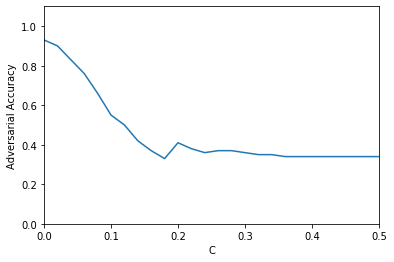

In [14]:
# Choose an optimiser parameter
param = "C"

# Choose a range of values
param_range = (0, 0.5)

# Choose the step size - the metric will be computed at each value of the 
# parameter
step_size = 0.02

# Choose a metric
metric = adversarial_accuracy

# Use the evaluator to compute the metric over the range of parameter values
# Set the kwargs to compute the correct set of results for the metric - in this
# case we need to adversarially perturb the images, so we set adversarial to
# True
param_values, all_scores = stain_evaluator.metric_vs_strength(param, param_range, 
                                                              step_size, metric,
                                                              adversarial=True)

# Use the helper function to plot the scores against the parameter values
fig = plot_change(param_values, all_scores, xlabel=param, 
                  ylabel="Adversarial Accuracy", x_range=param_range, 
                  y_range=(0, 1.1))

And we can transform specific inputs by passing a list of indices to the evaluator, and visualise the results

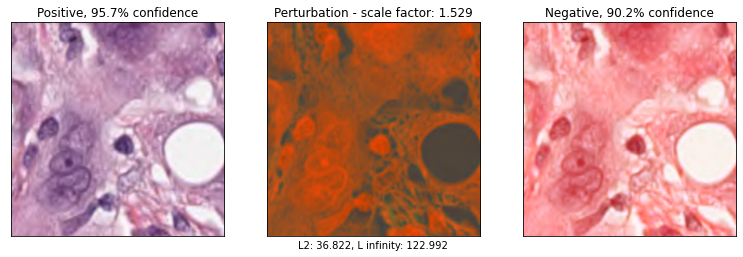

In [15]:
inputs, adv_inputs = stain_evaluator.attack_inputs([0])
for i, input_ in enumerate(inputs):
    display_results(model, input_, adv_inputs[i], classes)

Here we have an example of using a transform with stochastic search. To demonstrate how this differs from using PGD we manually define the optimiser and transform parameters below, but you could also simply import them from `constants.py` as shown previously. 

Note that the optimiser parameters are different. We define: `samples`, the number of randomly sampled parameter sets we test; `weight_ranges`, a dictionary with the name of each parameter in `self.weights` as keys and tuples defining the range of values that each parameter can take as values; and `input_range`, the minimum and maximum values the input data could take.

We define any necessary transform parameters - in this case we don't need any - and create an evaluator in the same way as before.

In [16]:
rotate_optimiser_params = {
    "samples": 20,
    "weight_ranges": {
        "angle": (0, 360)
    },
    "input_range": (0, 255)
}

rotate_transform_params = {
}

rotate_evaluator = Evaluator(model, test_dataset, small_loader, StochasticSearch, 
                             RotateTransform, rotate_optimiser_params, 
                             rotate_transform_params, device=device)

We can do all the same operations as before, like measuring robustness and visualising the effects of the transform.

Accuracy: 0.930, robust accuracy: 0.520, fooling ratio: 0.441


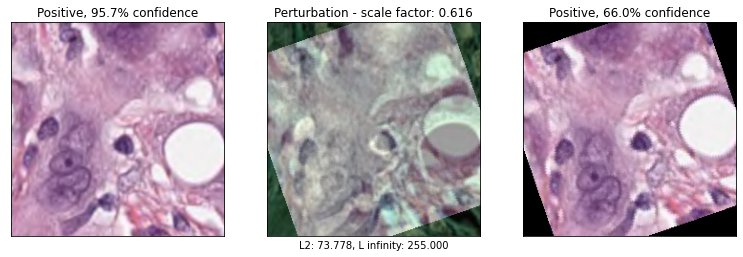

In [17]:
results = rotate_evaluator.predict(adversarial=True)

# Compute a standard set of metrics
get_metrics(results)

inputs, adv_inputs = rotate_evaluator.attack_inputs([0])
for i, input_ in enumerate(inputs):
    display_results(model, input_, adv_inputs[i], classes)

We can define new transforms to work with the existing optimisers. Below we show how to define a transform for use with the PGD optimiser.

In [18]:
from torch.autograd import Variable
from reetoolbox.transforms import Transform

class MeanTransform(Transform):
    # The class inherits from the abstract class Transform
    def __init__(self, input_shape, device, input_range=(0, 255), noise_range=(-0.1, 0.1)):
        # This method must take input_shape and device and input, and can 
        # optionally take any other desired arguments
        super().__init__(input_shape, device)

        self.input_range = input_range
        batch_size = input_shape[0]
        shape = (batch_size, 1)

        # self.base_weights defines the base perturbation from which to measure
        # the magnitude of the perturbation. Often it will be a tensor of zeros
        self.base_weights = torch.zeros(shape).to(device)

        # self.weights is a tensor with a grad function that will be optimised
        # using the provided optimiser to cause misclassification
        weights = torch.FloatTensor(*shape).uniform_(*noise_range).to(device)
        self.weights = Variable(weights, requires_grad=True).to(device)

    def forward(self, x):
        # We want to use this transfrom with PGD, so this must perform a 
        # differentiable (with respect to self.weights) transform on the inputs 
        # x. The transform is parameterised by self.weights
        for i in range(self.input_shape[0]):
            x[i] = torch.clamp(x[i] + self.weights[i], *self.input_range)
        return x

In [19]:
# Create an evaluator using our new transform
mean_optimiser_params = {
    "epsilon": 0.5,
    "steps": 20,
    "constraint": "l2",
    "C": 30,
    "input_range": (0, 255)
}

mean_transform_params = {
    "input_range": (0, 255)
}

mean_evaluator = Evaluator(model, test_dataset, small_loader, PGD, 
                           MeanTransform, mean_optimiser_params, 
                           mean_transform_params, device=device)

results = mean_evaluator.predict(adversarial=True)
get_metrics(results)

Accuracy: 0.930, robust accuracy: 0.850, fooling ratio: 0.086
